In [83]:
# %load notebooks/utils/get_dataframes.py
import pandas as pd

DATA_DIR = 'data'
MUTANTS_CONTEXT = '{0}/{1}/mutants.context'
KILL_CSV = '{0}/{1}/kill.csv'


def get_subject(subject):

    mutants_context_df = pd.read_csv(MUTANTS_CONTEXT.format(DATA_DIR, subject))
    kill_df = pd.read_csv(KILL_CSV.format(DATA_DIR, subject))

    del mutants_context_df['mutationOperatorGroup']
    del mutants_context_df['nodeTypeDetailed']
    del mutants_context_df['nodeContextBasic']
    del mutants_context_df['astContextDetailed']
    del mutants_context_df['parentContextBasic']
    del mutants_context_df['parentContextDetailed']
    del mutants_context_df['parentStmtContextBasic']
    del mutants_context_df['parentStmtContextDetailed']

    kill = []

    for i in mutants_context_df['mutantNo']:

        search = kill_df.query('MutantNo == %d' % i)

        if len(search) > 0:
            kill.append(search.iloc[0, 1])
        else:
            kill.append(None)

    mutants_context_df['kill'] = kill

    return mutants_context_df.dropna(axis=0, how='any').reset_index(drop=True)


def get_subjects(subjects):
    mutant_context_df = None

    for subject in subjects:
        if mutant_context_df is not None:
            mutant_context_df = mutant_context_df.append(
                get_subject(subject))
        else:
            mutant_context_df = get_subject(subject)

    return mutant_context_df.reset_index(drop=True)



In [48]:

# %load notebooks/utils/get_x.py
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer


def get_x(df):
    vectorizer_ast = CountVectorizer(ngram_range=(1, 4), analyzer='word')
    ast_vectorized = vectorizer_ast.fit_transform(
        df['astContextBasic'])

    vectorizer_mutation_op = CountVectorizer()
    mutation_op_vectorized = vectorizer_mutation_op.fit_transform(
        df['mutationOperator'])

    vectorizer_node_type = CountVectorizer()
    node_type_vectorized = vectorizer_node_type.fit_transform(
        df['nodeTypeBasic'])

    ast_df = pd.DataFrame(
        ast_vectorized.A,
        columns=vectorizer_ast.get_feature_names())

    mutation_op_df = pd.DataFrame(
        mutation_op_vectorized.A,
        columns=vectorizer_mutation_op.get_feature_names())

    node_type_df = pd.DataFrame(
        node_type_vectorized.A,
        columns=vectorizer_node_type.get_feature_names())

    x = df.iloc[:, 4:7]
    x = x.join(ast_df.add_prefix('ast_'))
    x = x.join(mutation_op_df.add_prefix('mop_'))
    x = x.join(node_type_df.add_prefix('nty_'))

    return x

In [49]:
# %load notebooks/utils/get_y.py
def get_y(df, column):
    status_to_nonequivalent = {
        'FAIL': 'NON_EQUIVALENT',
        'TIME': 'NON_EQUIVALENT',
        'EXC': 'NON_EQUIVALENT',
        'LIVE': 'MAYBE_EQUIVALENT'
    }

    status_to_trivial = {
        'FAIL': 'NON_TRIVIAL',
        'TIME': 'NON_TRIVIAL',
        'EXC': 'TRIVIAL',
        'LIVE': 'NON_TRIVIAL'
    }

    df['non_equivalent'] = df['kill'].str.upper().map(status_to_nonequivalent)
    df['trivial'] = df['kill'].str.upper().map(status_to_trivial)

    return df[column]

In [114]:
# %load notebooks/utils/metrics.py
from sklearn import metrics


def measure_performance(X, y, clf):
    y_predicted = clf.predict(X)
    print('Accuracy: %f \n' % metrics.accuracy_score(y, y_predicted))
    print(metrics.classification_report(y, y_predicted), '\n')

In [118]:
# %load notebooks/utils/samples.py
def get_samples(df, label, frac=0.1, replace=True):
    X = get_x(df)
    X['y'] = get_y(df, label)

    X_train = X.sample(frac=frac, replace=replace)

    y = X['y']
    y_train = X_train['y']

    X = X.drop(['y'], axis=1)
    X_train = X_train.drop(['y'], axis=1)

    return X, y, X_train, y_train


In [158]:
from sklearn import tree

label = 'non_equivalent'

subjects = [
    'Closure-8', 'Closure-12', 'Closure-5', 'Closure-132',
    'Closure-130', 'Closure-55', 'Lang-1', 'Lang-31', 'Lang-59'
]


mutant_context_df = get_subjects(subjects)

X, y, X_train, y_train = get_samples(mutant_context_df, label, frac=0.2)


clf = tree.DecisionTreeClassifier(criterion='gini', max_depth=4)

clf = clf.fit(X_train, y_train)


measure_performance(X, y, clf)

Accuracy: 0.767519 

                  precision    recall  f1-score   support

MAYBE_EQUIVALENT       0.73      0.16      0.27      1874
  NON_EQUIVALENT       0.77      0.98      0.86      5361

     avg / total       0.76      0.77      0.71      7235
 



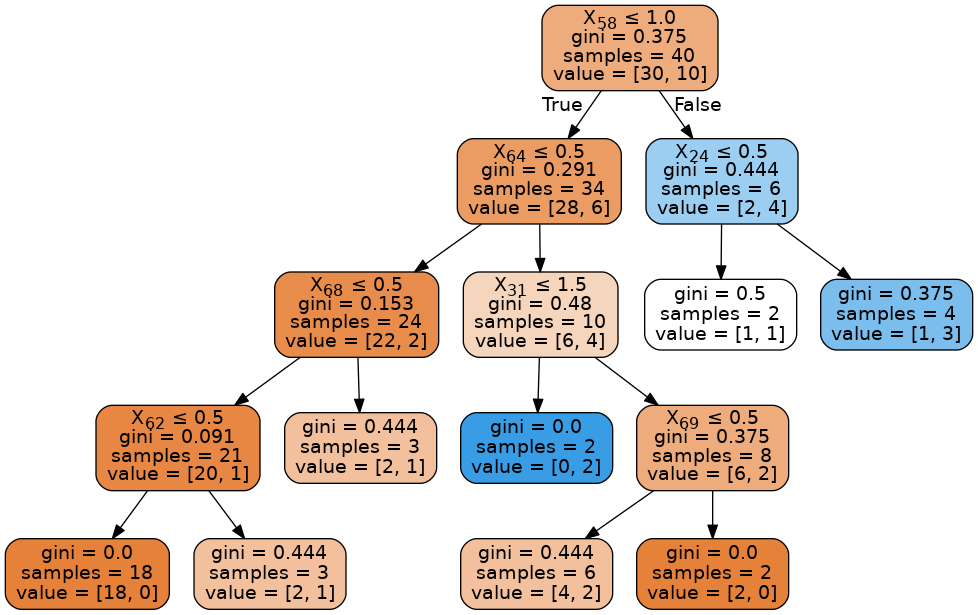

In [130]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())
